In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

import shutil
import os

dataset_path = '/content/gdrive/MyDrive/Colab Notebooks'
shutil.copy(os.path.join(dataset_path, 'feature_log-mel_96_rs_df.pickle'), 'feature_log-mel_96_rs_df.pickle')

Mounted at /content/gdrive/


'feature_log-mel_96_rs_df.pickle'

In [2]:
import numpy as np
import pandas as pd

from datetime import datetime

In [3]:
# load feature data

import pickle

with open('feature_log-mel_96_rs_df.pickle','rb') as f:
    dataset_df = pickle.load(f)

In [4]:
# split data

from sklearn.model_selection import train_test_split

# Split the dataset
X = np.array(dataset_df['feature'].tolist())
y = np.array(dataset_df['label'].tolist())

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=1, stratify=Y_test)


In [5]:
# Add dimension for the channel

X_train = X_train.reshape(-1,32,129,3)
X_val = X_val.reshape(-1,32,129,3)
X_test = X_test.reshape(-1,32,129,3)

print(X_train.shape, X_val.shape, X_test.shape)

(5097, 32, 129, 3) (1093, 32, 129, 3) (1092, 32, 129, 3)


In [21]:
# transfer learning

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.applications import MobileNet

pre_trained_model = VGG19(weights='imagenet', include_top=False, input_shape=(32,129,3))
pre_trained_model.summary()

model = Sequential()
model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))                          # 0.25 오버피팅 발생함
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['acc'])
model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 129, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 129, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 129, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 64, 128)       147584    
                                                              

In [22]:
# callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(filepath='best_fcn.hdf5', # filename
                                monitor='val_loss',   # val_accuracy 값이 개선되었을때 호출
                                verbose=1,                # 로그 출력
                                save_best_only=True,      # 가장 best 값 저장
                                mode='auto')              # 알아서 best 찾음

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss)
                               patience=5,        # 3회 Epoch동안 개선되지 않는다면 종료
                               verbose=1
                              )

# checkpointer = ModelCheckpoint(filepath='best_fcn.hdf5',
#                                monitor='val_accuracy', verbose=1,
#                                save_best_only=True)

#callbacks = [checkpoint, earlystopping]
callbacks = [checkpoint]

In [ ]:
# run model

epochs = 150
batch_size = 256

hist = model.fit(X_train, Y_train,
              batch_size=batch_size, epochs=epochs,
              validation_data=(X_val, Y_val), callbacks=callbacks,
              verbose=1)


Epoch 1/150
20/20 [==============================] - ETA: 0s - loss: 2.5871 - acc: 0.1685
Epoch 1: val_loss improved from inf to 2.00629, saving model to best_fcn.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 40s 1s/step - loss: 2.5871 - acc: 0.1685 - val_loss: 2.0063 - val_acc: 0.2479
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 1.9644 - acc: 0.2823
Epoch 2: val_loss improved from 2.00629 to 1.66143, saving model to best_fcn.hdf5
20/20 [==============================] - 8s 409ms/step - loss: 1.9644 - acc: 0.2823 - val_loss: 1.6614 - val_acc: 0.4703
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.6512 - acc: 0.4155
Epoch 3: val_loss improved from 1.66143 to 1.28351, saving model to best_fcn.hdf5
20/20 [==============================] - 8s 429ms/step - loss: 1.6512 - acc: 0.4155 - val_loss: 1.2835 - val_acc: 0.6157
Epoch 4/150
20/20 [==============================] - ETA: 0s - loss: 1.4144 - acc: 0.5242
Epoch 4: val_loss improved from 1.28351 to 1.03112, saving model to best_fcn.hdf5
20/20 [==============================] - 8s 408ms/step - loss: 1.4144 - acc: 0.5242 - val_loss: 1.0311 - val_acc: 0.6715
Ep

In [18]:
# Evaluating the model on the training and testing set

best_model = load_model('best_fcn.hdf5')
score = best_model.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy: ", score[1])
score = best_model.evaluate(X_val, Y_val, verbose=0)
print("Validation Accuracy: ", score[1])
score = best_model.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy: ", score[1])


Training Accuracy:  0.9996076226234436
Validation Accuracy:  0.7099725604057312
Testing Accuracy:  0.7179487347602844


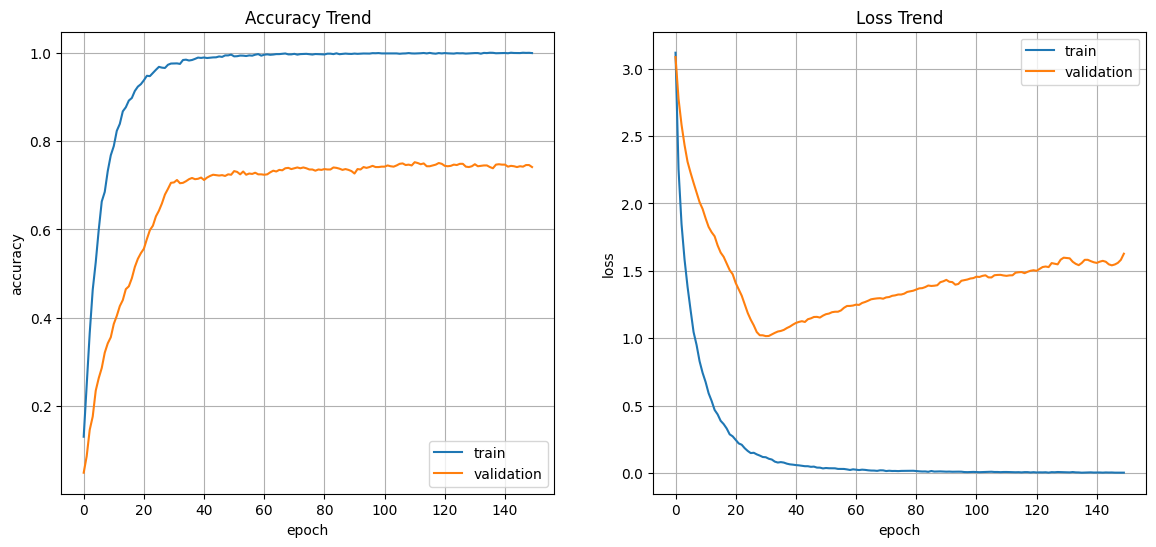

In [10]:
# plot trend of accuracy & loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
ax1.plot(hist.history['acc'], label='train')
ax1.plot(hist.history['val_acc'], label='validation')
ax1.set_title('Accuracy Trend')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(loc='best')
ax1.grid()
ax2 = plt.subplot(1,2,2)
ax2.plot(hist.history['loss'], label='train')
ax2.plot(hist.history['val_loss'], label='validation')
ax2.set_title('Loss Trend')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(loc='best')
ax2.grid()
plt.show()


35/35 [==============================] - 1s 14ms/step


<Axes: title={'center': 'Confusion Matrix'}>

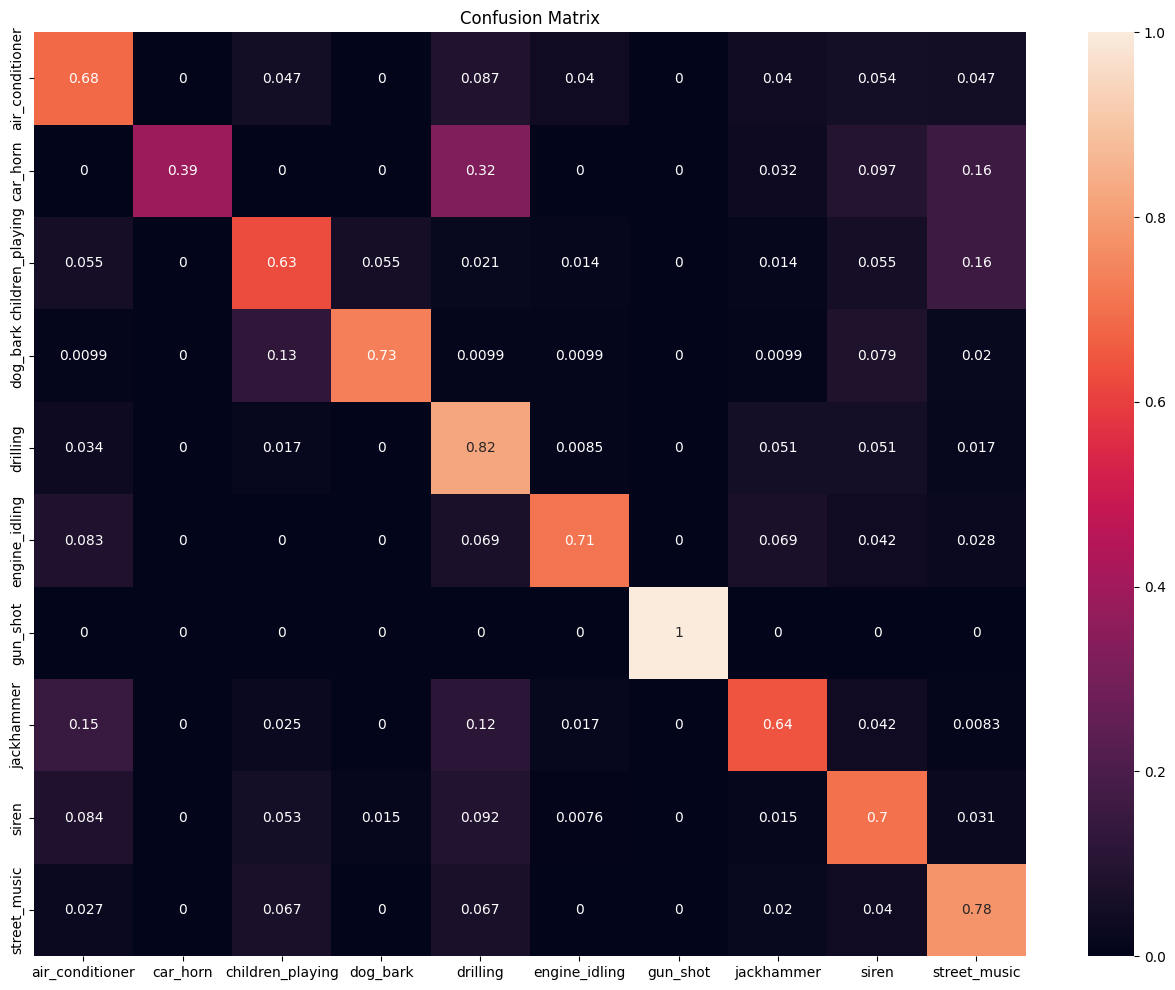

In [11]:
# plot confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = best_model.predict(X_test)
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

class_dic = {3: 'dog_bark', 2: 'children_playing', 1: 'car_horn',
              0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot',
              8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}
classes = [class_dic[key] for key in sorted(class_dic.keys())]

normalize = True

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm, index =[i for i in classes],columns=[i for i in classes])

plt.figure(figsize=(16,12))
plt.title('Confusion Matrix')
sns.heatmap(df_cm,annot=True)


35/35 [==============================] - 1s 14ms/step


<ipython-input-12-bc8abb594674>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(concepts)
<ipython-input-12-bc8abb594674>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(concepts)


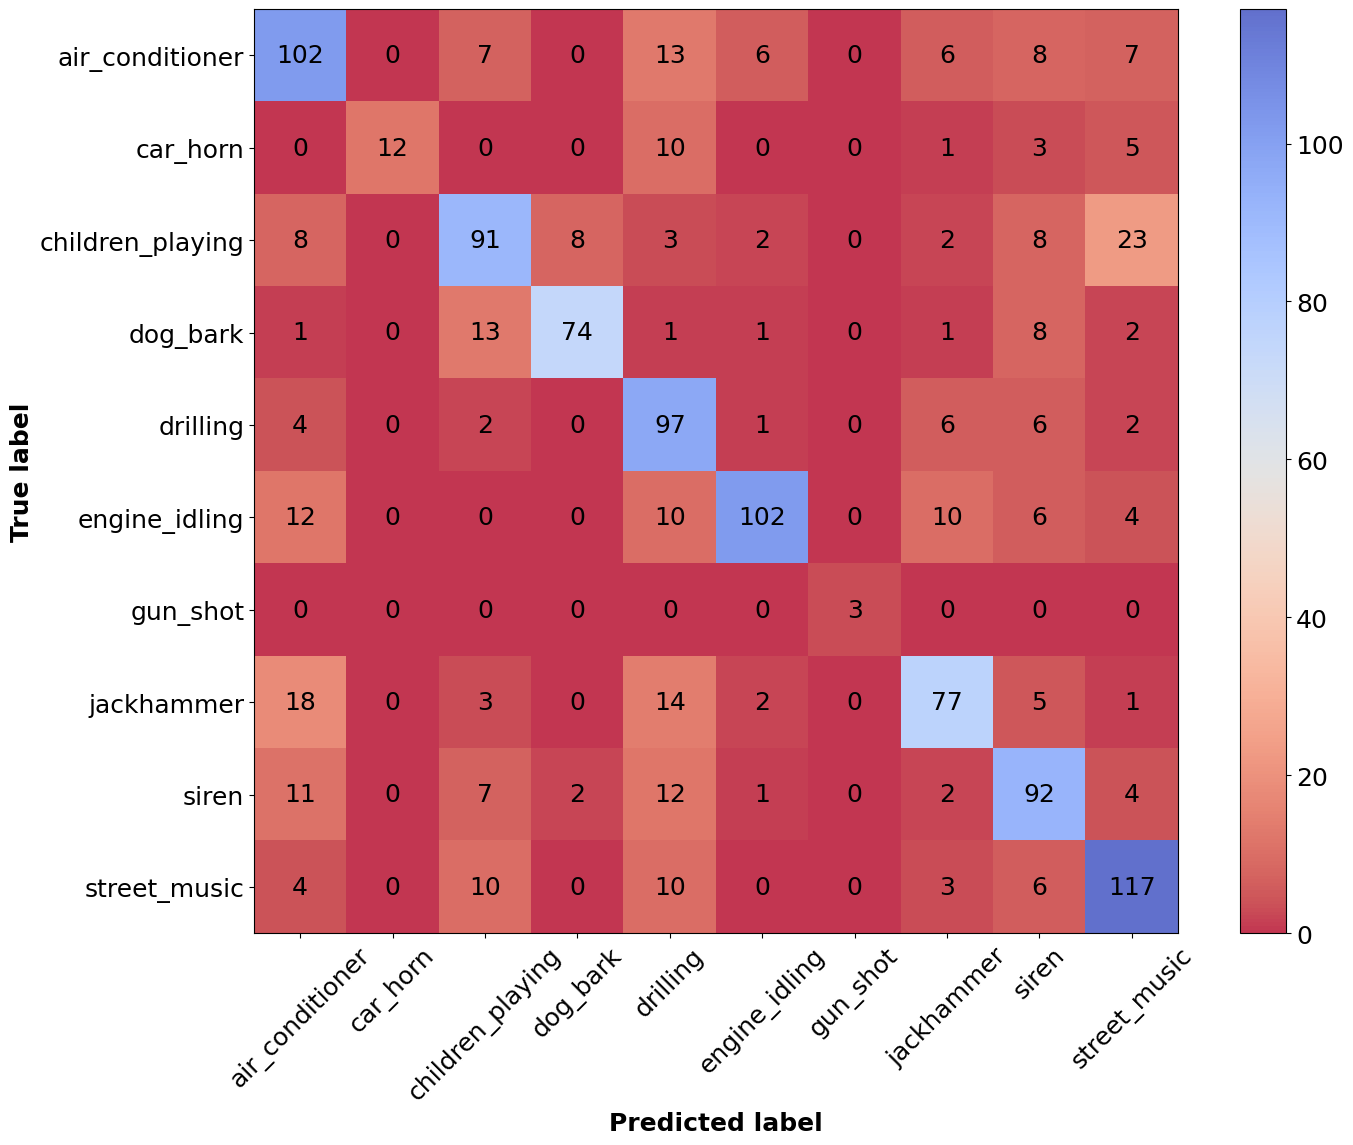

In [12]:
# Plot a confusion matrix

from sklearn import metrics

Y_pred = best_model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

# Confusion matrix code (from https://github.com/triagemd/keras-eval/blob/master/keras_eval/visualizer.py)
def plot_confusion_matrix(cm, concepts, normalize=False, show_text=True, fontsize=18, figsize=(16, 12),
                          cmap=plt.cm.coolwarm_r, save_path=None, show_labels=True):

    if cm.ndim != 2 or cm.shape[0] != cm.shape[1]:
        raise ValueError('Invalid confusion matrix shape, it should be square and ndim=2')

    if cm.shape[0] != len(concepts) or cm.shape[1] != len(concepts):
        raise ValueError('Number of concepts (%i) and dimensions of confusion matrix do not coincide (%i, %i)' %
                          (len(concepts), cm.shape[0], cm.shape[1]))

    plt.rcParams.update({'font.size': fontsize})

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm_normalized
        print(cm)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, vmin=np.min(cm), vmax=np.max(cm), alpha=0.8, cmap=cmap)

    fig.colorbar(cax)
    ax.xaxis.tick_bottom()
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')

    if show_labels:
        n_labels = len(concepts)
        ax.set_xticklabels(concepts)
        ax.set_yticklabels(concepts)
#         plt.xticks(np.arange(0, n_labels, 1.0), rotation='vertical')
        plt.xticks(np.arange(0, n_labels, 1.0), rotation=45)
        plt.yticks(np.arange(0, n_labels, 1.0))
    else:
        plt.axis('off')

    fmt = '.2f' if normalize else 'd'
    if show_text:
        # http://stackoverflow.com/questions/21712047/matplotlib-imshow-matshow-display-values-on-plot
        min_val, max_val = 0, len(concepts)
        ind_array = np.arange(min_val, max_val, 1.0)
        x, y = np.meshgrid(ind_array, ind_array)
        for i, (x_val, y_val) in enumerate(zip(x.flatten(), y.flatten())):
            c = cm[int(x_val), int(y_val)]
            ax.text(y_val, x_val, format(c, fmt), va='center', ha='center')

    if save_path is not None:
        plt.savefig(save_path)

class_dictionary = {3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}
classes = [class_dictionary[key] for key in sorted(class_dictionary.keys())]

plot_confusion_matrix(matrix, classes)
